# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from bs4 import BeautifulSoup

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,auc,roc_curve,classification_report,precision_score,recall_score,f1_score, hamming_loss

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from prettytable import PrettyTable

from sklearn.tree import DecisionTreeClassifier

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:\Study_materials\Applied_AI\Assignments\database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (525814, 10)


In [3]:
sample_data = filtered_data.head(100000)

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=sample_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(sample_data['Id'].size*1.0)*100

87.775

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [9]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...


#  [3] Preprocessing

In [10]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

4
I wish I'd read the reviews before making this purchase. It's basically a cardsotck box that is sticky all over the OUTSIDE. Those pink-ish things that look like entrances "into" the trap? They're just pictures. There *is no* inside of the trap. All the flies will be stuck to the OUTSIDE. It's basically fly paper, just horribly, horribly HORRIBLY overpriced.<br /><br />Do yourself a favor and just get fly paper or fly strips. Same yuck factor, but much cheaper.


In [11]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'off', 'been', 'our', 'until', "you'd", 'my', 'against', 'then', 't', 'y', 'ma', "wouldn't", 'does', 'for', 'yourself', 'because', 'very', "hadn't", 'myself', "she's", 'this', 'under', 'have', 'wouldn', 'am', 'both', 'down', 'a', 'themselves', 'below', "you've", 'about', 'during', 'wasn', 'when', 'll', 'weren', "needn't", 'the', "won't", 'few', 'me', 'that', 'didn', "didn't", 'they', 'himself', 'he', "doesn't", 'are', 'his', 'than', "haven't", 're', 'whom', "weren't", 'more', 'and', 'from', 'doing', 'up', 'further', 'did', 'won', 'all', 'too', 'why', 'm', 'mightn', 'out', 'was', 'can', 'such', 'just', 'these', 'its', 'be', 'most', "mightn't", 'now', 'as', 'but', 'on', 'ours', "shouldn't", 'has', 'yours', 'what', 'd', 'hadn', 'who', "it's", "should've", 'at', 'haven', 'needn', 'how', 'after', 'no', 'is', 'she', "that'll", 'we', 'him', 'same', "wasn't", 'mustn', 'only', 'couldn', 'yourselves', 'nor', 'or', 'isn', 'each', 'her', 'were', 'don', "shan't", 's', 'before', 'other', 'into', 't

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.

final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [02:24<00:00, 606.35it/s]


In [13]:
final = final.sort_values('Time',axis = 0,ascending = True, inplace = False, kind = 'quicksort', na_position='last')

In [14]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [15]:
X  = final['CleanedText'].values
y = final['Score']

In [16]:
# Creating training, test and cross validation set

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train,y_train, test_size = 0.3, random_state=0) 

In [17]:
print("Size of X_train and y_train:", X_train.shape,y_train.shape)
print("Size of X_test and y_test:", X_test.shape,y_test.shape)
print("Size of X_tr and y_tr:", X_tr.shape,y_tr.shape)
print("Size of X_cv and y_cv:", X_cv.shape,y_cv.shape)

Size of X_train and y_train: (61441,) (61441,)
Size of X_test and y_test: (26332,) (26332,)
Size of X_tr and y_tr: (43008,) (43008,)
Size of X_cv and y_cv: (18433,) (18433,)


## Decision Tree Classifier

In [18]:
def DT_Classifier(X_train,X_cv,y_train,y_cv):
    pred_train = []
    pred_cv = []
    t_depth = [1, 5, 10, 50, 100, 500, 1000]
    sample_split = [5, 10, 100, 500] 
    for i in t_depth:
        for j in sample_split:
            clf = DecisionTreeClassifier(max_depth = i, min_samples_split = j)
            clf.fit(X_train,y_train)
            prob_train = clf.predict_proba(X_train)[:,1]
            prob_cv = clf.predict_proba(X_cv)[:,1]
            auc_score_train = roc_auc_score(y_train,prob_train)
            auc_score_cv = roc_auc_score(y_cv,prob_cv)
            pred_train.append(auc_score_train)
            pred_cv.append(auc_score_cv)
    cmap=sns.light_palette("green")
    # representing heat map for auc score
    print("-"*40, "AUC Score for train data", "-"*40)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(t_depth),len(sample_split))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=sample_split,yticklabels=t_depth)
    plt.xlabel('Sample Split')
    plt.ylabel('Depth')
    plt.show()
    print("-"*40, "AUC Score for CV data", "-"*40)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(t_depth),len(sample_split))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=sample_split, yticklabels=t_depth)
    plt.xlabel('Sample Split')
    plt.ylabel('Depth')
    plt.show()

## Testing model:

In [19]:
import scikitplot.metrics as skplt

def testing(X_train,y_train,X_test,y_test,optimal_depth,optimal_split):
    clf = DecisionTreeClassifier(max_depth = optimal_depth, min_samples_split = optimal_split)
    clf.fit(X_train,y_train)
    prob_train = clf.predict_proba(X_train)[:,1]
    prob_test = clf.predict_proba(X_test)[:,1]

    print("AUC Score for train data",roc_auc_score(y_train,prob_train))
    print("AUC Score for test data",roc_auc_score(y_test,prob_test))
    # calculate roc curve
    fpr_train, tpr_train, threshold_tr = roc_curve(y_train,prob_train)
    fpr_test, tpr_test, threshold_te = roc_curve(y_test,prob_test)
    
    # plot the roc curve for the model
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr_train, tpr_train, marker='.',color= 'r',label='Train Data')
    plt.plot(fpr_test, tpr_test, marker='.',color ='b',label='Test Data')
    plt.title("Line Plot of ROC Curve on Train Data and Test Data")
    plt.legend(loc='upper left')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()
    
    #plot confusion matrix
    
    prediction_train=clf.predict(X_train)
    prediction_test=clf.predict(X_test)
    
    print("macro f1 score for train data :",f1_score(y_train, prediction_train, average = 'macro'))
    print("macro f1 score for test data :",f1_score(y_test, prediction_test, average = 'macro'))
    print("micro f1 score for train data:",f1_score(y_train, prediction_train, average = 'micro'))
    print("micro f1 score for test data:",f1_score(y_test, prediction_test, average = 'micro'))
    print("hamming loss for train data:",hamming_loss(y_train,prediction_train))
    print("hamming loss for test data:",hamming_loss(y_test,prediction_test))
    print("Precision recall report for train data:\n",classification_report(y_train, prediction_train))
    print("Precision recall report for test data:\n",classification_report(y_test, prediction_test))
    skplt.plot_confusion_matrix(y_train,prediction_train,title='Confusion Matrix - Train Data')
    skplt.plot_confusion_matrix(y_test,prediction_test,title='Confusion Matrix - Test Data')

## Top 20 features:

In [20]:
def imp_feature(vectorizer,classifier, n =20):
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.feature_importances_, feature_names))
    top = coefs[:-(n + 1):-1]
    print('\033[1m' + "feature_importances\tfeatures" + '\033[0m')
    print("="*35)
    for (coef1, feat1) in top:
        print("%.4f\t\t\t%-15s" % (coef1, feat1))

## Techniques for vectorization :--

### 1. Bag of Words (BoW)

In [21]:
count_vec = CountVectorizer()
BOW_X_train = count_vec.fit_transform(X_tr)
BOW_X_cv = count_vec.transform(X_cv)
BOW_X_test = count_vec.transform(X_test)

In [22]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
BOW_X_train_sc = sc.fit_transform(BOW_X_train)
BOW_X_cv_sc = sc.transform(BOW_X_cv)
BOW_X_test_sc = sc.transform(BOW_X_test)

print("The shape of out text BOW vectorizer ",BOW_X_train_sc.get_shape())
print("CV Data Size: ",BOW_X_cv_sc.shape)
print("Test Data Size: ",BOW_X_test_sc.shape)

The shape of out text BOW vectorizer  (43008, 24467)
CV Data Size:  (18433, 24467)
Test Data Size:  (26332, 24467)


---------------------------------------- AUC Score for train data ----------------------------------------


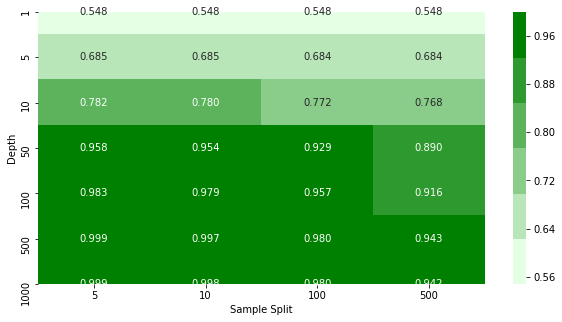

---------------------------------------- AUC Score for CV data ----------------------------------------


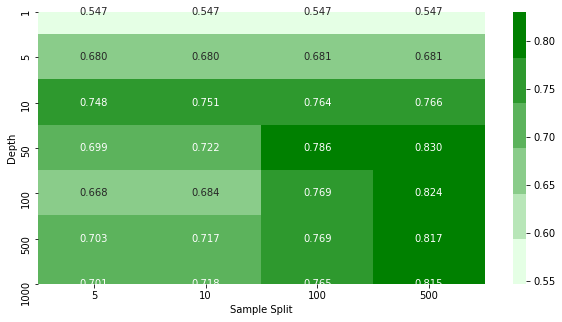

In [23]:
DT_Classifier(BOW_X_train_sc,BOW_X_cv_sc,y_tr,y_cv)

AUC Score for train data 0.889491634020241
AUC Score for test data 0.8198394958379458


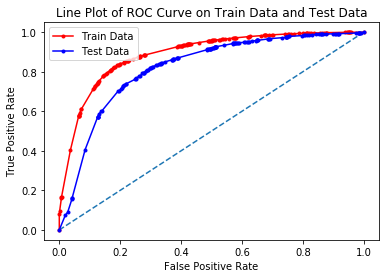

macro f1 score for train data : 0.755461884280308
macro f1 score for test data : 0.7033467018063027
micro f1 score for train data: 0.8834635416666666
micro f1 score for test data: 0.8603600182287711
hamming loss for train data: 0.11653645833333333
hamming loss for test data: 0.1396399817712289
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.70      0.49      0.58      6998
           1       0.91      0.96      0.93     36010

    accuracy                           0.88     43008
   macro avg       0.80      0.73      0.76     43008
weighted avg       0.87      0.88      0.87     43008

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.59      0.41      0.49      4234
           1       0.89      0.95      0.92     22098

    accuracy                           0.86     26332
   macro avg       0.74      0.68      0.70     26332
weighted avg       0.85  

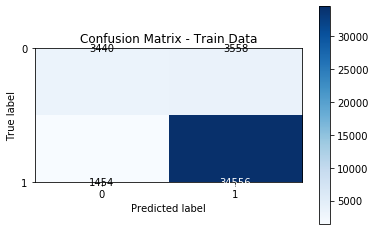

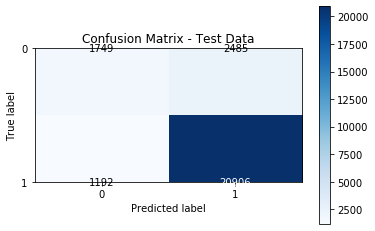

In [25]:
import scikitplot

testing(BOW_X_train_sc,y_tr,BOW_X_test_sc,y_test,optimal_depth=50,optimal_split=500)

## Top 20 Features:

In [26]:
clf = DecisionTreeClassifier(max_depth = 50, min_samples_split = 500)
clf.fit(BOW_X_train_sc,y_tr)
imp_feature(count_vec,clf)

feature_importances	features
0.0966			disappoint     
0.0617			great          
0.0488			return         
0.0471			bad            
0.0397			wast           
0.0332			worst          
0.0316			love           
0.0262			horribl        
0.0258			delici         
0.0241			best           
0.0217			perfect        
0.0198			aw             
0.0188			terribl        
0.0174			good           
0.0152			refund         
0.0138			favorit        
0.0137			disgust        
0.0136			unfortun       
0.0123			nice           
0.0119			excel          


### Visualize decision tree with Graphviz on BoW

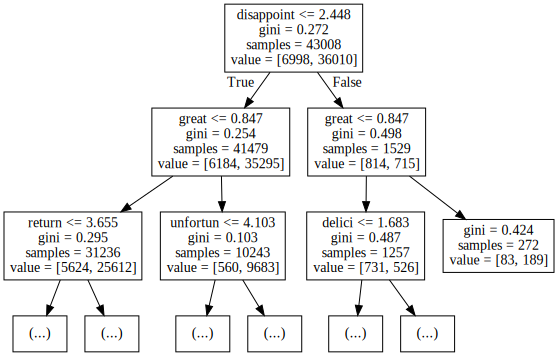

In [28]:
from sklearn import tree
from graphviz import Source
import graphviz
feat = count_vec.get_feature_names() 
Source(tree.export_graphviz(clf, out_file = None, feature_names = feat,max_depth=2))

### 2. TF-IDF

In [29]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vec.fit_transform(X_tr)
tfidf_cv = tf_idf_vec.transform(X_cv)
tfidf_test = tf_idf_vec.transform(X_test)

print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
print("Size of CV dataset:", tfidf_cv.shape)
print("Size of test dataset:", tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (43008, 683623)
Size of CV dataset: (18433, 683623)
Size of test dataset: (26332, 683623)


In [30]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
tfidf_train_sc = sc.fit_transform(tfidf_train)
tfidf_cv_sc = sc.transform(tfidf_cv)
tfidf_test_sc = sc.transform(tfidf_test)

---------------------------------------- AUC Score for train data ----------------------------------------


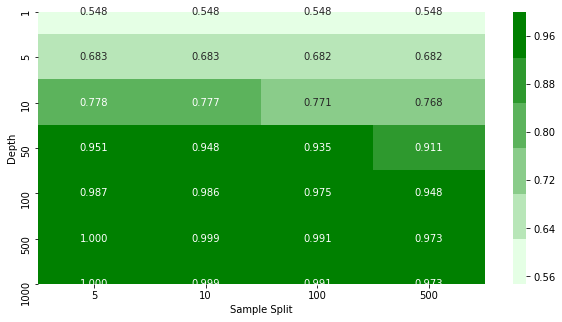

---------------------------------------- AUC Score for CV data ----------------------------------------


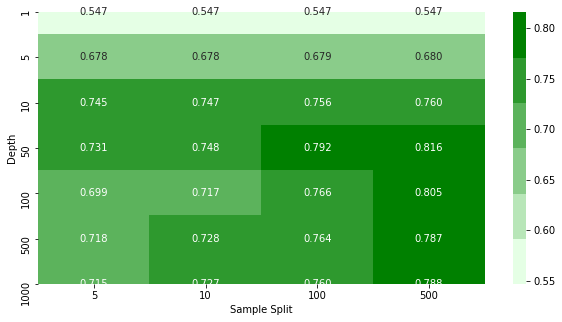

In [31]:
DT_Classifier(tfidf_train_sc,tfidf_cv_sc,y_tr,y_cv)

AUC Score for train data 0.911302287026269
AUC Score for test data 0.8101831770299801


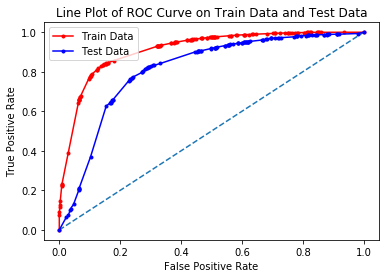

macro f1 score for train data : 0.7911008649423039
macro f1 score for test data : 0.7079217297188739
micro f1 score for train data: 0.8983909970238095
micro f1 score for test data: 0.8580434452377336
hamming loss for train data: 0.10160900297619048
hamming loss for test data: 0.14195655476226646
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.75      0.56      0.64      6998
           1       0.92      0.96      0.94     36010

    accuracy                           0.90     43008
   macro avg       0.84      0.76      0.79     43008
weighted avg       0.89      0.90      0.89     43008

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.58      0.44      0.50      4234
           1       0.90      0.94      0.92     22098

    accuracy                           0.86     26332
   macro avg       0.74      0.69      0.71     26332
weighted avg       0.85

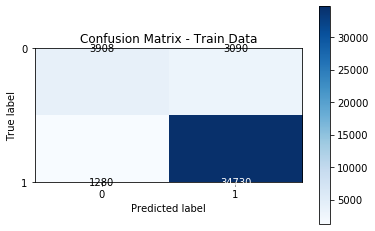

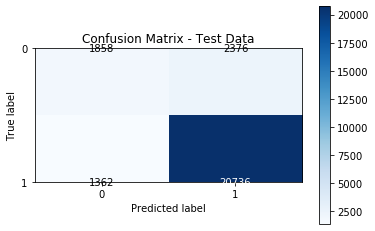

In [35]:
testing(tfidf_train_sc,y_tr,tfidf_test_sc,y_test,optimal_depth=50,optimal_split=500)

### Top 20 Features:

In [36]:
clf = DecisionTreeClassifier(max_depth = 50, min_samples_split = 500)
clf.fit(tfidf_train_sc,y_tr)
imp_feature(tf_idf_vec,clf)

feature_importances	features
0.0814			disappoint     
0.0507			great          
0.0435			return         
0.0398			bad            
0.0357			wast money     
0.0322			worst          
0.0285			love           
0.0246			delici         
0.0224			aw             
0.0216			horribl        
0.0194			best           
0.0176			good           
0.0170			terribl        
0.0160			perfect        
0.0153			refund         
0.0143			unfortun       
0.0131			wont buy       
0.0124			nice           
0.0124			wont disappoint
0.0116			high recommend 


### Visualize decision tree with Graphviz on TF-IDF

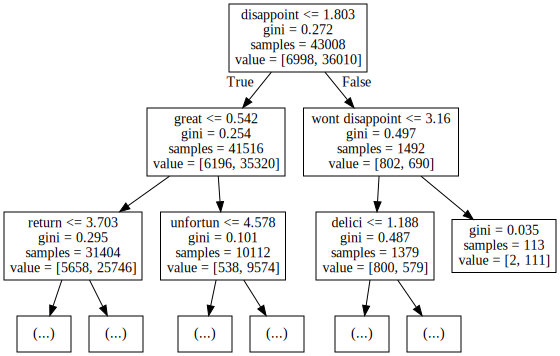

In [37]:
feat = tf_idf_vec.get_feature_names() 
Source(tree.export_graphviz(clf, out_file = None, feature_names = feat,max_depth=2))

### 3. Avg-W2V

In [38]:
i=0
list_sent_train=[]
for sent in X_tr:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_train.append(filtered_sentence)

In [39]:
i=0
list_sent_train1=[]
for sent in X_tr:
    filtered_sentence=[]
    sent=sent
    for w in sent.split():
        for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_train1.append(filtered_sentence)

In [40]:
i=0
list_sent_CV=[]
for sent in X_cv:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_CV.append(filtered_sentence)

In [41]:
i=0
list_sent_test=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_test.append(filtered_sentence)

In [42]:
import gensim
w2v_model = gensim.models.Word2Vec(list_sent_train,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [43]:
def avg_w2v(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)        
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [44]:
train_avgw2v = avg_w2v(list_sent_train)

43008
50


In [45]:
cv_avgw2v = avg_w2v(list_sent_CV)

18433
50


In [46]:
test_avgw2v = avg_w2v(list_sent_test)

26332
50


In [47]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
aw2v_X_train_sc = sc.fit_transform(train_avgw2v)
aw2v_X_cv_sc = sc.transform(cv_avgw2v)
aw2v_X_test_sc = sc.transform(test_avgw2v)

---------------------------------------- AUC Score for train data ----------------------------------------


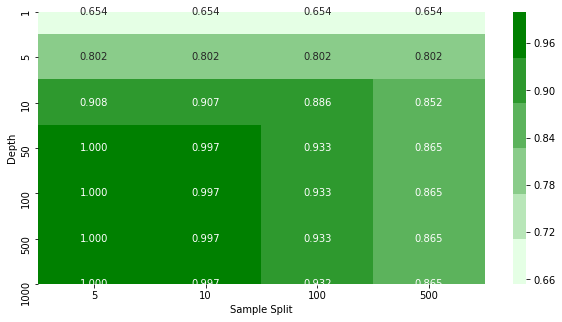

---------------------------------------- AUC Score for CV data ----------------------------------------


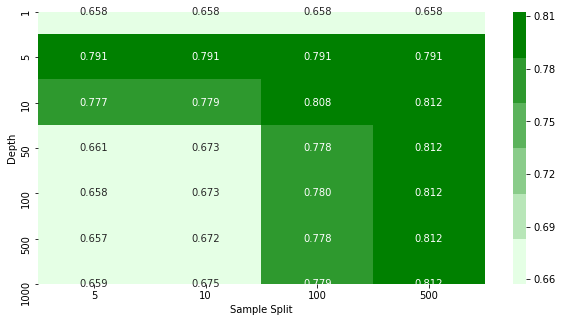

In [48]:
DT_Classifier(aw2v_X_train_sc,aw2v_X_cv_sc,y_tr,y_cv)

AUC Score for train data 0.8523611518632014
AUC Score for test data 0.8086549542932238


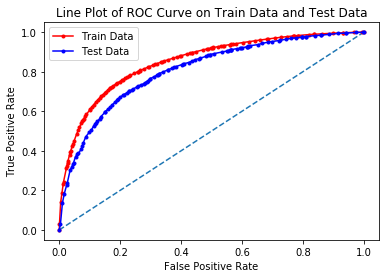

macro f1 score for train data : 0.6622345856559136
macro f1 score for test data : 0.6345106094311908
micro f1 score for train data: 0.8601422991071429
micro f1 score for test data: 0.8504481239556433
hamming loss for train data: 0.13985770089285715
hamming loss for test data: 0.14955187604435669
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.66      0.29      0.40      6998
           1       0.88      0.97      0.92     36010

    accuracy                           0.86     43008
   macro avg       0.77      0.63      0.66     43008
weighted avg       0.84      0.86      0.84     43008

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.58      0.25      0.35      4234
           1       0.87      0.96      0.92     22098

    accuracy                           0.85     26332
   macro avg       0.73      0.61      0.63     26332
weighted avg       0.82

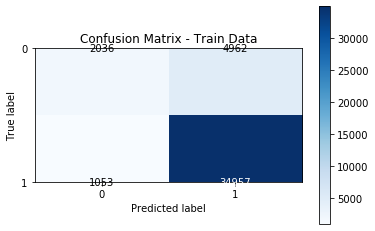

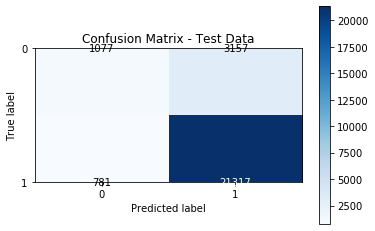

In [49]:
testing(aw2v_X_train_sc,y_tr,aw2v_X_test_sc,y_test,optimal_depth=10,optimal_split=500)

### 4. TF_IDF-W2V

In [50]:
tf_idf_vect = TfidfVectorizer()
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (43008, 24467)
CV Data Size:  (18433, 24467)
Test Data Size:  (26332, 24467)


In [51]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_train = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in tqdm(list_sent_train):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|████████████████████████████████████████████████████████████████████████████| 43008/43008 [16:14<00:00, 44.15it/s]


43008
50


In [52]:
import time
start1 = time.clock()
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_sent_CV):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_cv[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_CV))
print(len(tfidf_sent_vectors_CV[0]))
print((time.clock()-start1)/60)

100%|████████████████████████████████████████████████████████████████████████████| 18433/18433 [06:38<00:00, 46.27it/s]


18433
50
6.640942736849926


In [53]:
start2 = time.clock()
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_sent_test):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))
print((time.clock()-start1)/60)

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [09:43<00:00, 45.12it/s]


26332
50
16.36961633088334


In [54]:
train_tfidfw2v = tfidf_sent_vectors_train
cv_tfidfw2v = tfidf_sent_vectors_CV
test_tfidfw2v = tfidf_sent_vectors_test

In [55]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
tfidfw2v_X_train_sc = sc.fit_transform(train_tfidfw2v)
tfidfw2v_X_cv_sc = sc.transform(cv_tfidfw2v)
tfidfw2v_X_test_sc = sc.transform(test_tfidfw2v)

---------------------------------------- AUC Score for train data ----------------------------------------


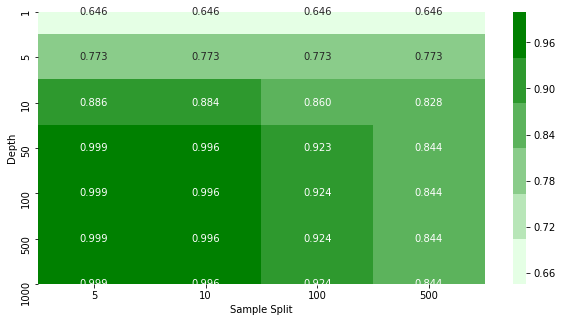

---------------------------------------- AUC Score for CV data ----------------------------------------


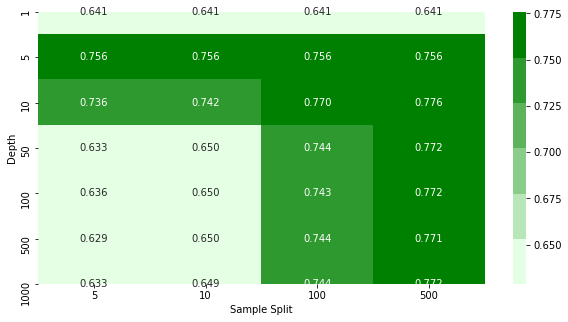

In [56]:
DT_Classifier(tfidfw2v_X_train_sc,tfidfw2v_X_cv_sc,y_tr,y_cv)

AUC Score for train data 0.8281853588667656
AUC Score for test data 0.7793927834583037


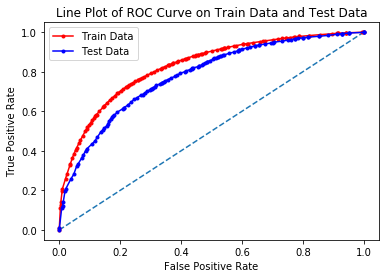

macro f1 score for train data : 0.6407959239802589
macro f1 score for test data : 0.6185155443281607
micro f1 score for train data: 0.8544224330357143
micro f1 score for test data: 0.8471441591979341
hamming loss for train data: 0.14557756696428573
hamming loss for test data: 0.15285584080206593
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.63      0.26      0.36      6998
           1       0.87      0.97      0.92     36010

    accuracy                           0.85     43008
   macro avg       0.75      0.61      0.64     43008
weighted avg       0.83      0.85      0.83     43008

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.56      0.23      0.32      4234
           1       0.87      0.97      0.91     22098

    accuracy                           0.85     26332
   macro avg       0.71      0.60      0.62     26332
weighted avg       0.82

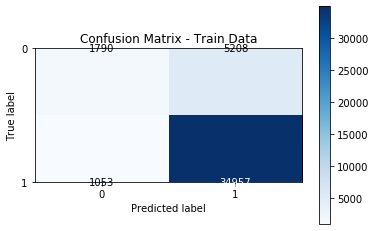

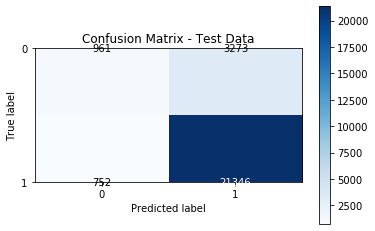

In [57]:
testing(tfidfw2v_X_train_sc,y_tr,tfidfw2v_X_test_sc,y_test,optimal_depth=10,optimal_split=500)

In [59]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","Best Hyper Parameter(Depth)","Best Hyper parameter(min_split)","Test Auc Score"]
x.add_row(["BoW",50,500, 81.98])
x.add_row(["Tf-Idf",50,500,81.01])
x.add_row(["Avg-W2V",10,500,80.86])
x.add_row(["TfIdf-W2V",10,100,77.93])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+------------+-----------------------------+---------------------------------+----------------+
| Vectorizer | Best Hyper Parameter(Depth) | Best Hyper parameter(min_split) | Test Auc Score |
+------------+-----------------------------+---------------------------------+----------------+
|    BoW     |              50             |               500               |     81.98      |
|   Tf-Idf   |              50             |               500               |     81.01      |
|  Avg-W2V   |              10             |               500               |     80.86      |
| TfIdf-W2V  |              10             |               100               |     77.93      |
+------------+-----------------------------+---------------------------------+----------------+
